In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

setPath = 'C:/temp/v6'
csv_file_path = setPath + '/data/responses.csv'
df = pd.read_csv(csv_file_path)
print(csv_file_path)

X = df[['clearance','speed','thickness']].to_numpy()
# y = df['response'].to_numpy()
y = abs(df['response'] - 0.1875).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:/Users/ags22007/OneDrive - University of Connecticut/Abaqus/Final/scripts/responses.csv


<AxesSubplot:>

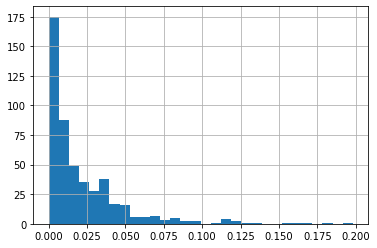

In [2]:
abs(df['response'] - 0.1875).hist(bins=30)

In [3]:
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS

model = KRG()
model.set_training_values(X_train, y_train)
model.train()

y_pred = model.predict_values(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set:", mse)

C:\Users\ags22007\AppData\Roaming\Python\Python39\site-packages\smt\surrogate_models\gpx.py:23: UserWarning: To use GPX you have to install dependencies: pip install smt['gpx']
  warnings.warn("To use GPX you have to install dependencies: pip install smt['gpx']")
C:\Users\ags22007\AppData\Roaming\Python\Python39\site-packages\smt\surrogate_models\krg_based.py:486: UserWarning: Warning: multiple x input features have the same value (at least same row twice).
  warnings.warn(


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 392
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 20.6016674
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 99
   
   Predicting ...
   Predicting - done. Time (sec):  0.1100078
   
   Prediction time/pt. (sec) :  0.0011112
   
Mean Squared Error on Test Set: 0.0011954383452889743


In [4]:
from scipy.optimize import minimize

# restrictions
min_clearance = 0.000
max_clearance = 0.010
min_speed = -2.0
max_speed = -0.1
min_thickness = 0.001
max_thickness = 0.015

bounds = [(min_clearance, max_clearance),
          (min_speed, max_speed),
          (min_thickness, max_thickness)]

# bounds = [(np.min(X_train[:,0]), np.max(X_train[:,0])),
#           (np.min(X_train[:,1]), np.max(X_train[:,1])),
#           (np.min(X_train[:,2]), np.max(X_train[:,2]))]

x0 = np.mean(X_train, axis=0) # initial guess

parameters_history = []
objective_history = []

# define objective function to minimize
def objective_function(X):
    X_reshaped = X.reshape(1,-1) 
    prediction = model.predict_values(X_reshaped)
    parameters_history.append(X)
    objective_history.append(prediction[0][0])
    print(prediction)
    return prediction.ravel()[0]  

result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

print("Optimal parameters:", result.x)
print("Minimum response:", result.fun)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0042102
   
   Prediction time/pt. (sec) :  0.0042102
   
[[0.02341797]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0020034
   
   Prediction time/pt. (sec) :  0.0020034
   
[[0.01000059]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009995
   
   Prediction time/pt. (sec) :  0.0009995
   
[[0.00916201]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0009997
   
   Prediction time/pt. (sec) :  0.0009997
   
[[0

   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   
[[0.01083918]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0081775
   
   Prediction time/pt. (sec) :  0.0081775
   
[[0.0158707]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0010028
   
   Prediction time/pt. (sec) :  0.0010028
   
[[0.01335494]]
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1
   
   Predicting ...
   Predicting - done. Time (sec):  0.0030043
   
   Prediction time/pt. (sec) :  0.0030043
   
[[0.01000059]]
_________________________________________________________________

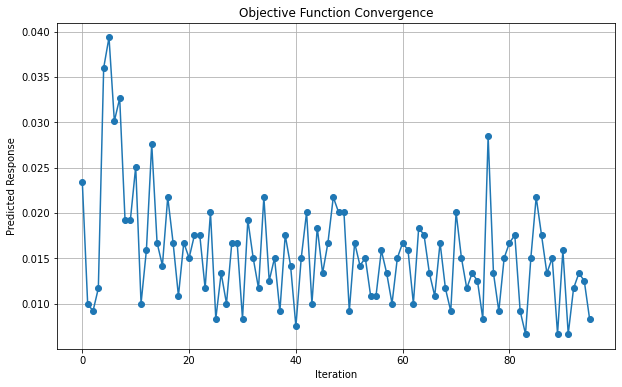

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(objective_history, marker='o')
plt.title('Objective Function Convergence')
plt.xlabel('Iteration')
plt.ylabel('Predicted Response')
plt.grid(True)
plt.show()


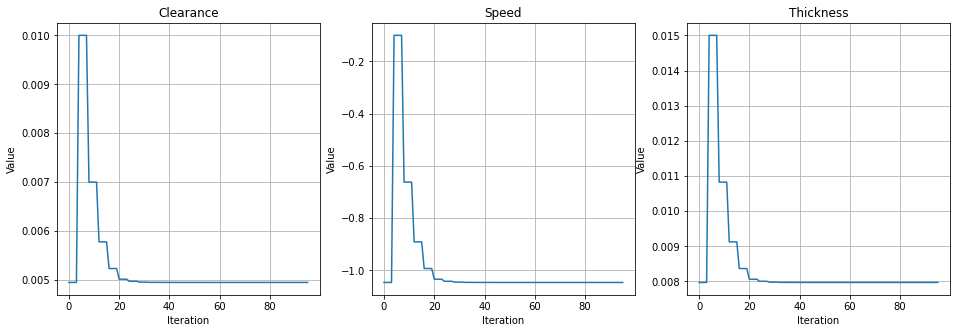

In [6]:
fig,ax = plt.subplots(1,3, figsize=(16, 5))

parameters_history = np.array(parameters_history)

ax[0].plot(parameters_history[:, 0])
ax[0].set(title='Clearance', xlabel='Iteration', ylabel='Value')
ax[0].grid(True)
ax[1].plot(parameters_history[:, 1])
ax[1].set(title='Speed', xlabel='Iteration', ylabel='Value')
ax[1].grid(True)
ax[2].plot(parameters_history[:, 2])
ax[2].set(title='Thickness', xlabel='Iteration', ylabel='Value')
ax[2].grid(True)

plt.show()

## Bayesian Optimization

In [7]:
# !pip install scikit-optimize

In [8]:
from skopt import gp_minimize
from scipy.interpolate import NearestNDInterpolator

bounds = [(min_clearance, max_clearance),
          (min_speed, max_speed),
          (min_thickness, max_thickness)]

interpolator = NearestNDInterpolator(X, y)

def objective(args):
    clearance, speed, thickness = args
    params = np.array([[clearance, speed, thickness]])
    predicted_response = interpolator(params)
    return predicted_response.item()

# Now we call gp_minimize from skopt
res_gp = gp_minimize(objective, bounds, n_calls=200, random_state=0)

print("Best parameters: {}".format(res_gp.x))
print("Best objective: {}".format(res_gp.fun))

Best parameters: [0.003124782285876981, -1.3570613749242457, 0.008445230171449648]
Best objective: 0.000180432499999994


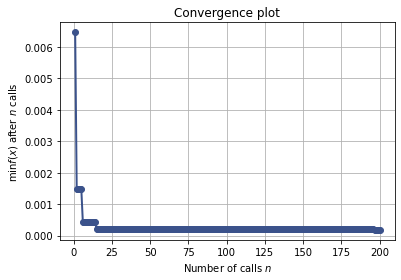

In [9]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

plot_convergence(res_gp)
plt.show()

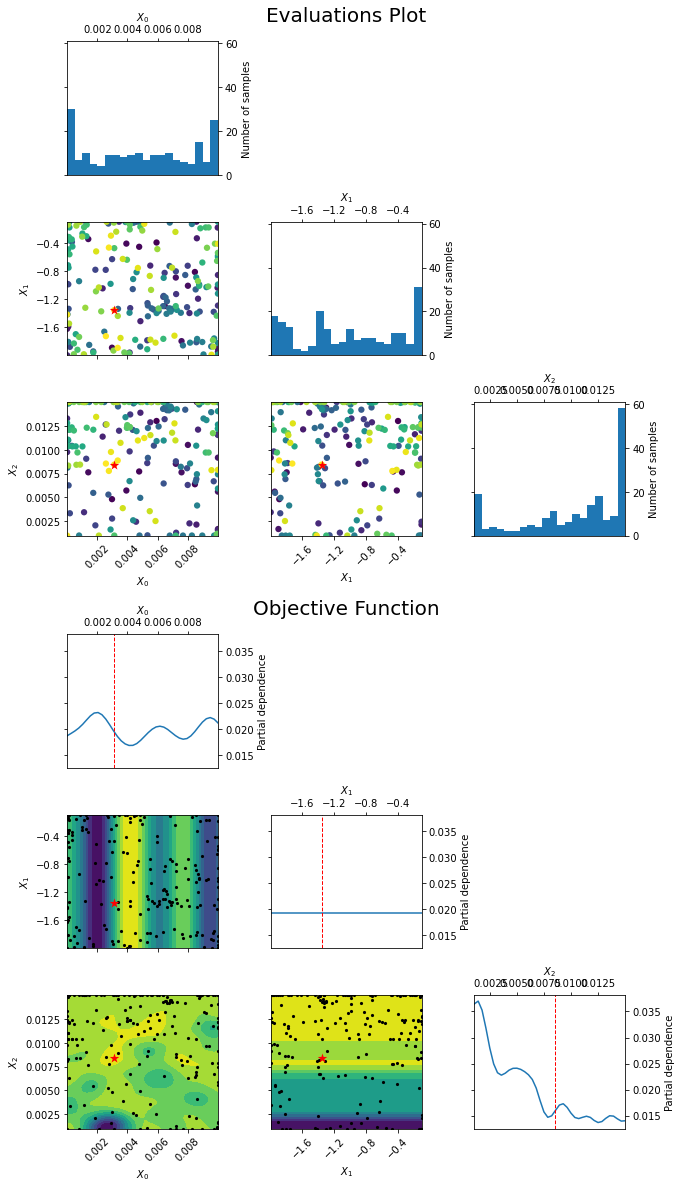

In [10]:
# res_gp.x_iters

fig,ax = plt.subplots(2,1, figsize=(10,20))
plot_evaluations(res_gp, bins=20, ax=ax[0])
ax[0].set_title('Evaluations Plot', fontsize=20, pad=20)
plot_objective(res_gp, n_samples=100, ax=ax[1])
ax[1].set_title('Objective Function', fontsize=20, pad=20)

plt.show()